In [148]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
data_dir = "../"

# Resource Utilisation

Resource utilisation was measured during the creation and termination of deployments. This notebook displays the average total deployment and termination times depending on different resource combinations. Additionally, the cpu and memory utilisation during the deployment and termination processes is visualized. Each configuration has been tested three times (except all)  each for different amounts of concurrent deployments:
- Single OpenFaaS (resource 1, function 1) with concurrent deployments: 1, 2, 4,6, 8  
- Single Lambda (resources 14, 15, function 1) with concurrent deployments: 1, 2, 4, 6
- Single K8S (resource 6, service 1) with concurrent deployments: 1, 2, 4, 6
- Single EC2 (resource 12, function 1) with concurrent deployments: 1
- Multiple OpenFaaS (resources 1, 2, 3, function 1) with concurrent deployments: 1, 2, 4, 6
- Multi Multiple  OpenFaaS (resources 1, 2, 3, function 1, 2, 3 on all resources) with concurrent deployments: 1, 2, 4, 6
- All (resources 1, 2, 3, 6, 12,  14, 15, function 1, service 1) with concurrent deployments: 1

The original data can be found in [reaction_time](../utilisation)

In [149]:
ru_dir = os.path.join(data_dir, "utilisation")

In [150]:
df_timestamps = pd.DataFrame()
df_util = pd.DataFrame()

for root, dirs, files in os.walk(ru_dir):
       for subdir in dirs:
              curr_ru_dir = os.path.join(root, subdir)               
              start_timestamp = 0
              finish_timestamp = 2_000_000_000_000
              for file_path in glob.glob(curr_ru_dir + "/*.csv"):
                     df = pd.read_csv(file_path)
                     df["type"] = subdir
                     concurrent_deployments = file_path.split(curr_ru_dir)[1].split('_')[3].split('.')[0]
                     df['concurrent_deployments'] = int(concurrent_deployments)
              
                     if file_path.endswith('_util.csv'):
                            df = df.drop('id', axis=1)
                            df = df.drop(df[df["timestamp"] > (finish_timestamp + 30000)].index)
                            df["timestamp"] = df["timestamp"] - start_timestamp
                            df_util = pd.concat([df_util, df.drop_duplicates(subset=['timestamp', 'cpu', 'memory'])], ignore_index=True)
                     else:
                            # TODO: remove
                            if subdir == 'multiple_multi_openfaas' or subdir == 'all':
                                   df["deployed"] = df["deployed"] / 1000
                                   df["terminated"] = df["terminated"] / 1000
                            else:
                                   df["start_response_time"] = df["start_response"] - df["start"]
                                   df["terminate_response_time"] = df["terminate_response"] - df["terminate"]
                            start_timestamp = df["start"].min()
                            finish_timestamp = df["terminated"].max()
                            df["start"] = df["start"] - start_timestamp
                            df["deployed"] = df["deployed"] - start_timestamp
                            df["terminate"] = df["terminate"] - start_timestamp
                            df["terminated"] = df["terminated"] - start_timestamp
                            df["deployment_time"] = df["deployed"] - df["start"]
                            df["termination_time"] = df["terminated"] - df["terminate"]
                            df_timestamps = pd.concat([df_timestamps, df], ignore_index=True)

In [151]:
df_timestamps

,id,request_idx,deployment_id,start,deployed,terminate,terminated,function_deployments,service_deployments,type,concurrent_deployments,deployment_time,termination_time,start_response,terminate_response,start_response_time,terminate_response_time
0,0,0,763,0,239612.0,246543,305145.0,6,1,all,1,239612.0,58602.0,NaN,NaN,NaN,NaN
1,0,0,605,0,51348.0,57950,70924.0,9,0,multiple_multi_openfaas,1,51348.0,12974.0,NaN,NaN,NaN,NaN
2,1,0,606,74150,125831.0,132049,145021.0,9,0,multiple_multi_openfaas,1,51681.0,12972.0,NaN,NaN,NaN,NaN
3,2,0,607,148748,205452.0,212051,224127.0,9,0,multiple_multi_openfaas,1,56704.0,12076.0,NaN,NaN,NaN,NaN
4,0,0,608,0,47765.0,58966,73210.0,9,0,multiple_multi_openfaas,2,47765.0,14244.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,2,3,935,248289,331561.0,342806,353556.0,1,0,single_openfaas,8,83272.0,10750.0,1.710795e+12,1.710795e+12,1668.0,1852.0
237,2,4,937,248340,310509.0,342850,353148.0,1,0,single_openfaas,8,62169.0,10298.0,1.710795e+12,1.710795e+12,2620.0,1700.0
238,2,5,940,248388,318339.0,342894,354526.0,1,0,single_openfaas,8,69951.0,11632.0,1.710795e+12,1.710795e+12,3772.0,2970.0
239,2,6,942,248436,334764.0,342938,353873.0,1,0,single_openfaas,8,86328.0,10935.0,1.710795e+12,1.710795e+12,4721.0,2724.0


In [152]:
df_util

,timestamp,cpu,memory,type,concurrent_deployments
0,-23786,0.099700,615653376,all,1
1,-5786,0.104785,614674432,all,1
2,8214,0.152921,622039040,all,1
3,28214,0.253216,636182528,all,1
4,46214,0.803559,657641472,all,1
...,...,...,...,...,...
565,318549,4.049962,5853237248,single_openfaas,8
566,338549,1.021901,5642317824,single_openfaas,8
567,349549,3.565827,6127173632,single_openfaas,8
568,363549,1.825613,2528202752,single_openfaas,8


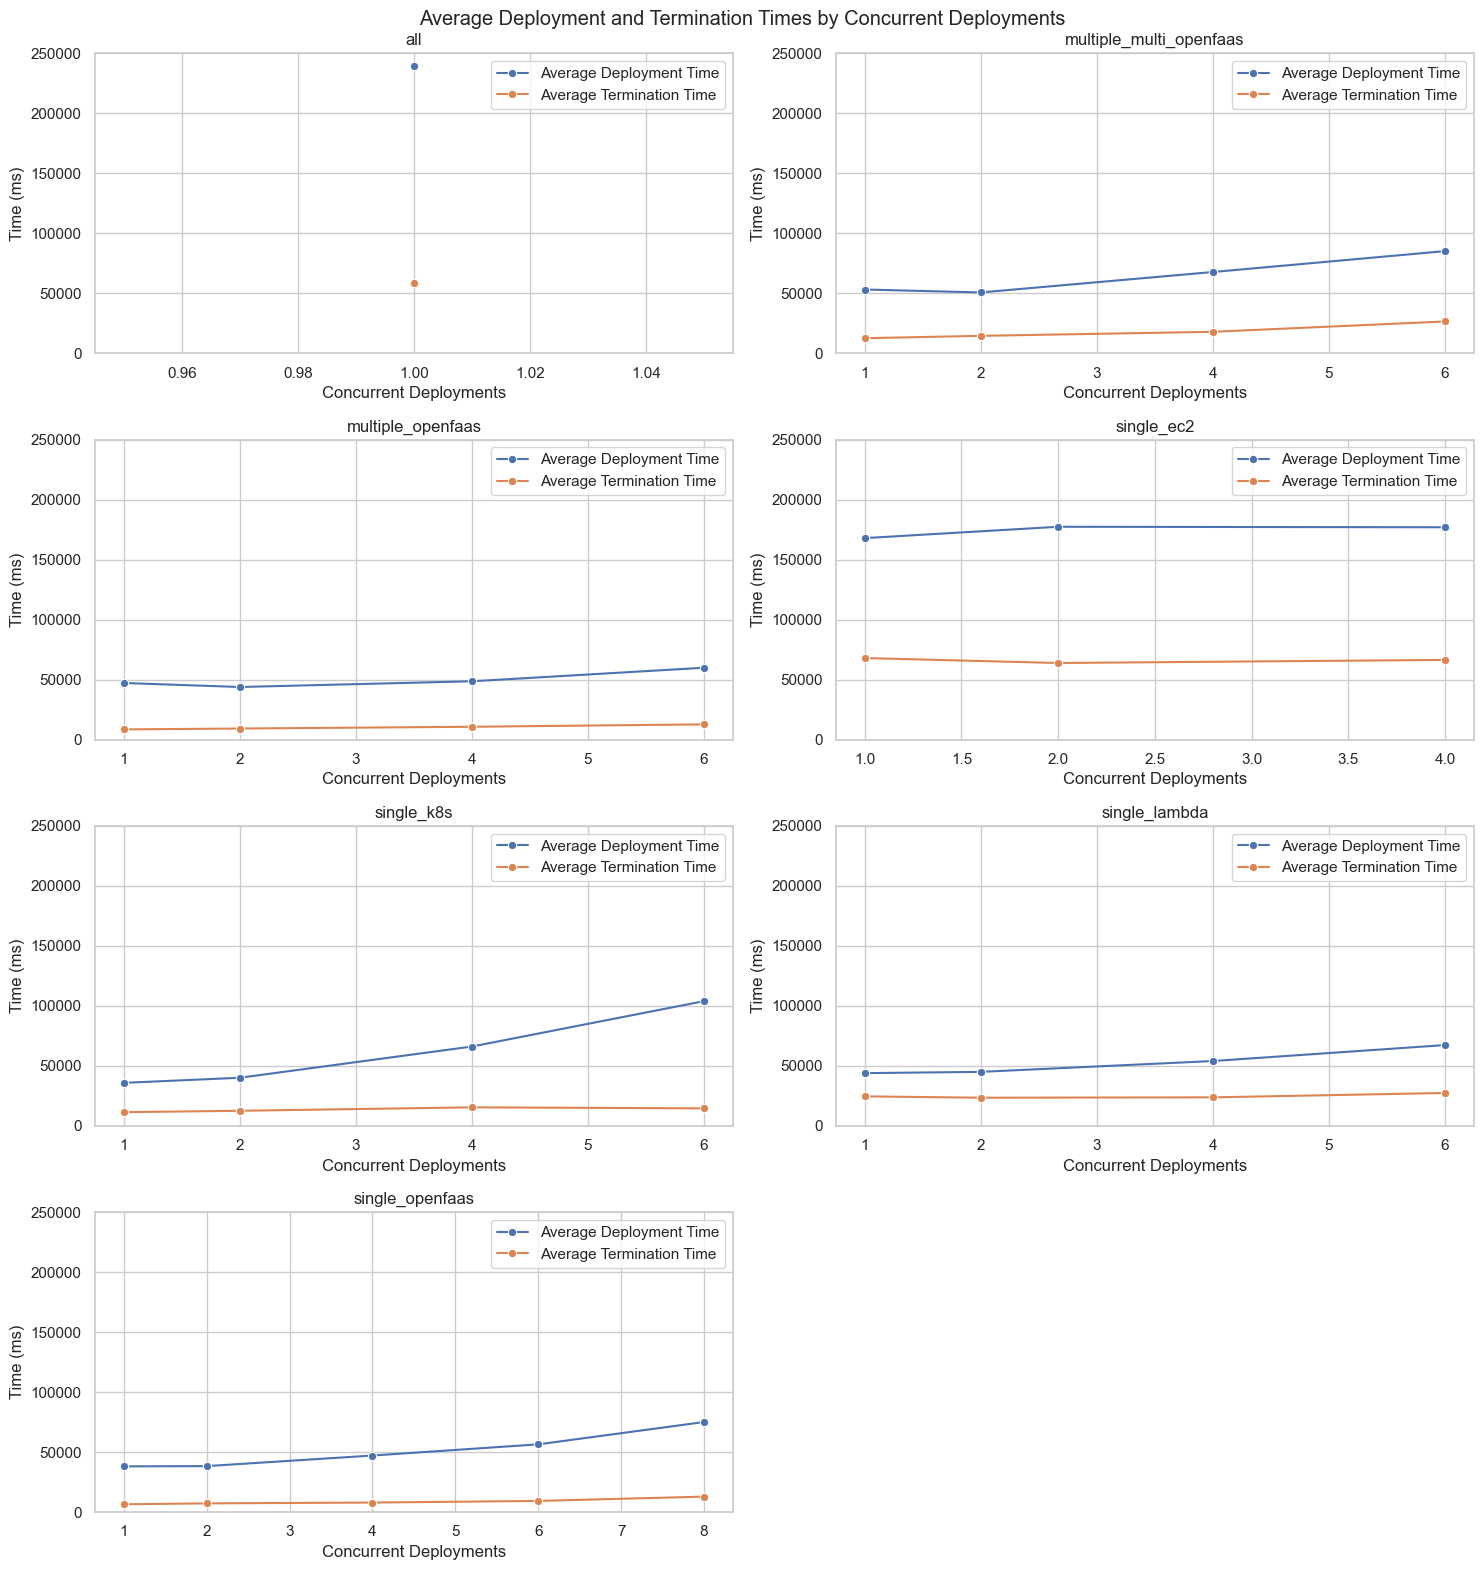

In [153]:
grouped_timestamps = df_timestamps.groupby(['type', 'concurrent_deployments']).mean().reset_index()

types = grouped_timestamps['type'].unique()

num_rows = (len(types) + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 4*num_rows))
axs = axs.flatten()
y_min = 0
y_max = 250_000
for i, type_ in enumerate(types):
       subset_df = grouped_timestamps[grouped_timestamps['type'] == type_]
       sns.lineplot(data=subset_df, x='concurrent_deployments', y='deployment_time', ax=axs[i], label='Average Deployment Time', marker='o')
       sns.lineplot(data=subset_df, x='concurrent_deployments', y='termination_time', ax=axs[i], label='Average Termination Time', marker='o')
       axs[i].set_ylim(y_min, y_max)
       axs[i].set_xlabel('Concurrent Deployments')
       axs[i].set_ylabel('Time (ms)')
       axs[i].set_title(f'{type_}')
for ax in axs[len(types):]:
       ax.axis('off')
plt.suptitle('Average Deployment and Termination Times by Concurrent Deployments')
plt.tight_layout()
plt.show()

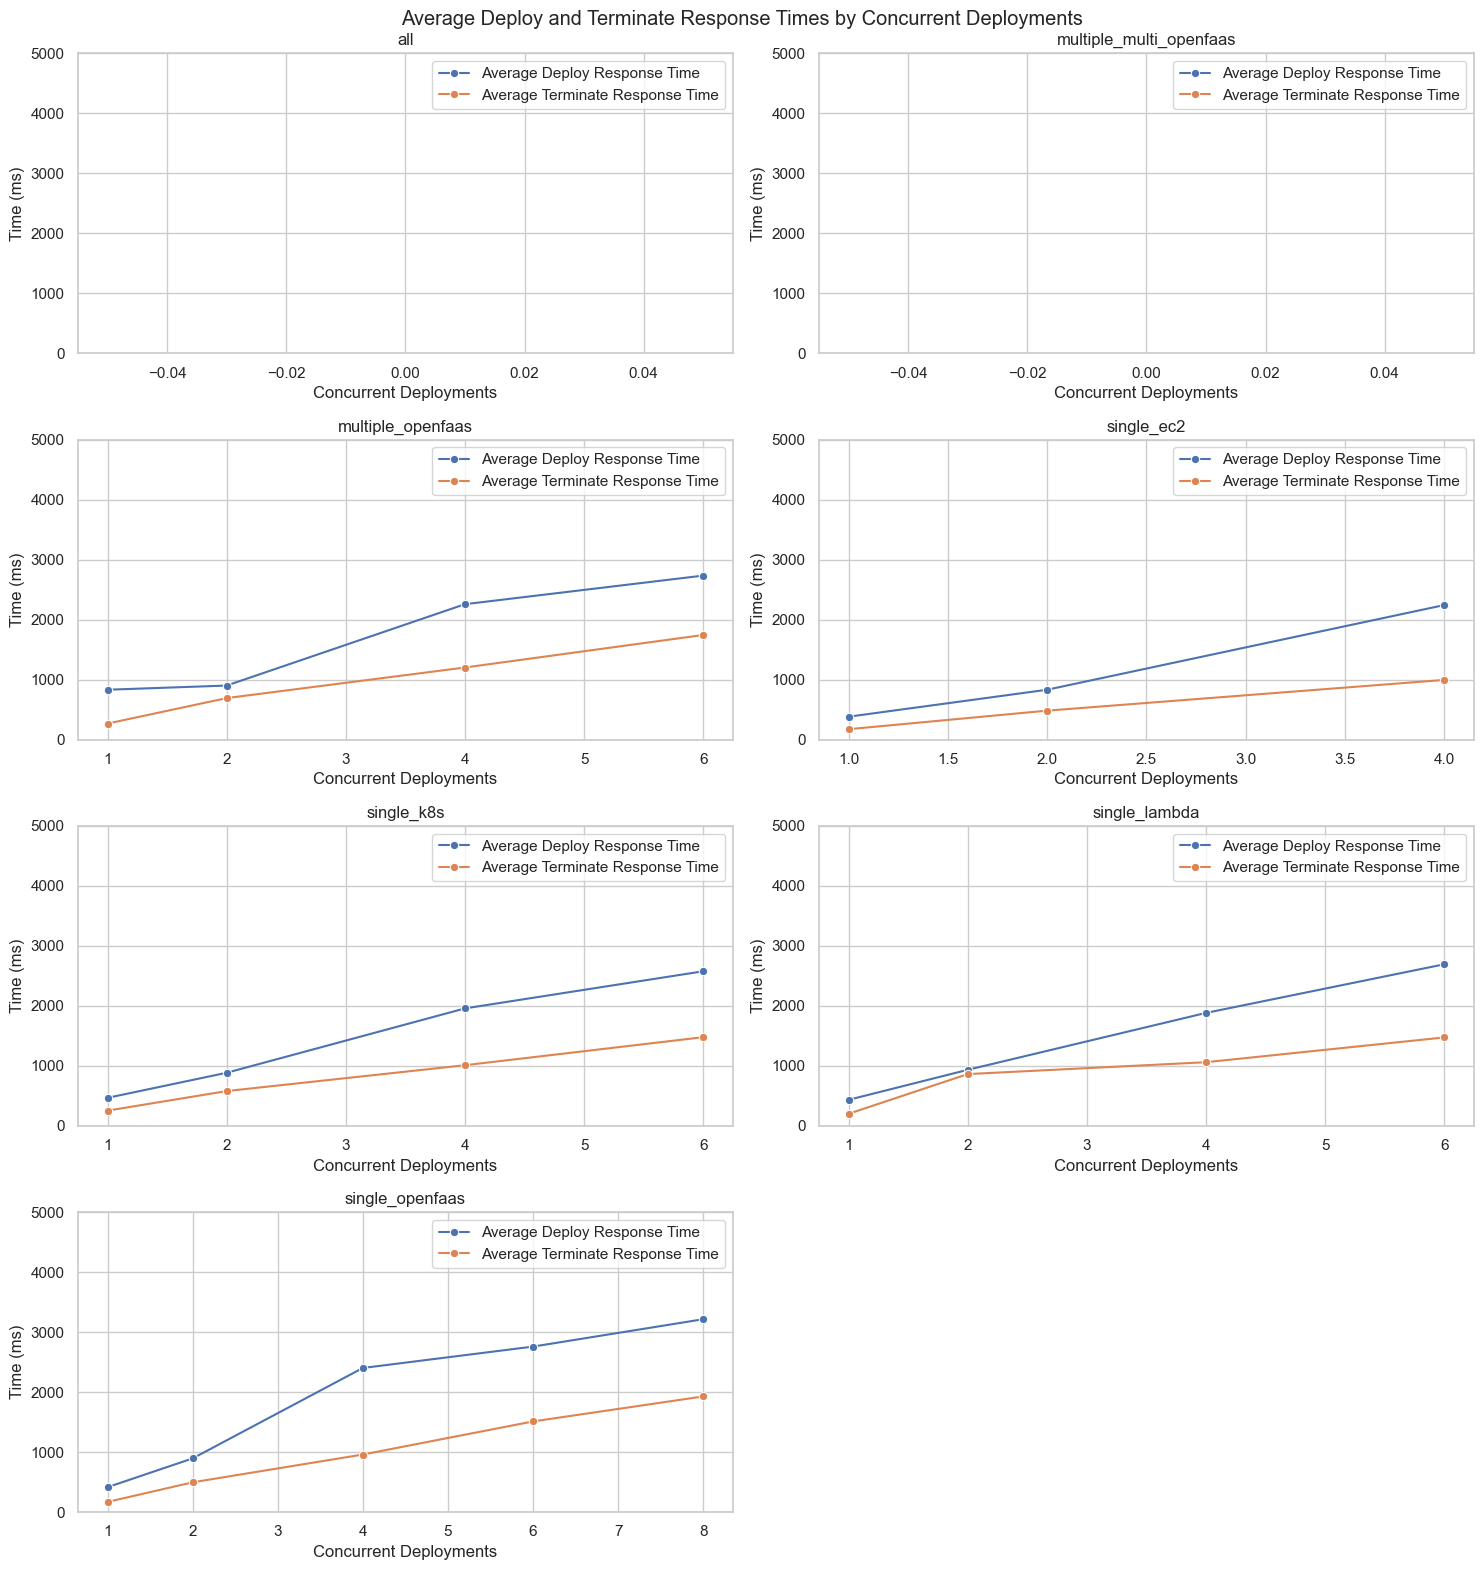

In [154]:
grouped_timestamps = df_timestamps.groupby(['type', 'concurrent_deployments']).mean().reset_index()

types = grouped_timestamps['type'].unique()

num_rows = (len(types) + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 4*num_rows))
axs = axs.flatten()
y_min = 0
y_max = 5_000
for i, type_ in enumerate(types):
       subset_df = grouped_timestamps[grouped_timestamps['type'] == type_]
       sns.lineplot(data=subset_df, x='concurrent_deployments', y='start_response_time', ax=axs[i], label='Average Deploy Response Time', marker='o')
       sns.lineplot(data=subset_df, x='concurrent_deployments', y='terminate_response_time', ax=axs[i], label='Average Terminate Response Time', marker='o')
       axs[i].set_ylim(y_min, y_max)
       axs[i].set_xlabel('Concurrent Deployments')
       axs[i].set_ylabel('Time (ms)')
       axs[i].set_title(f'{type_}')
for ax in axs[len(types):]:
       ax.axis('off')
plt.suptitle('Average Deploy and Terminate Response Times by Concurrent Deployments')
plt.tight_layout()
plt.show()

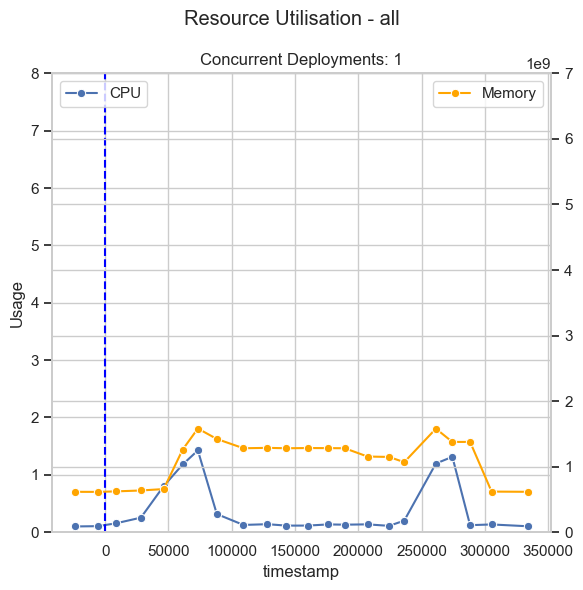

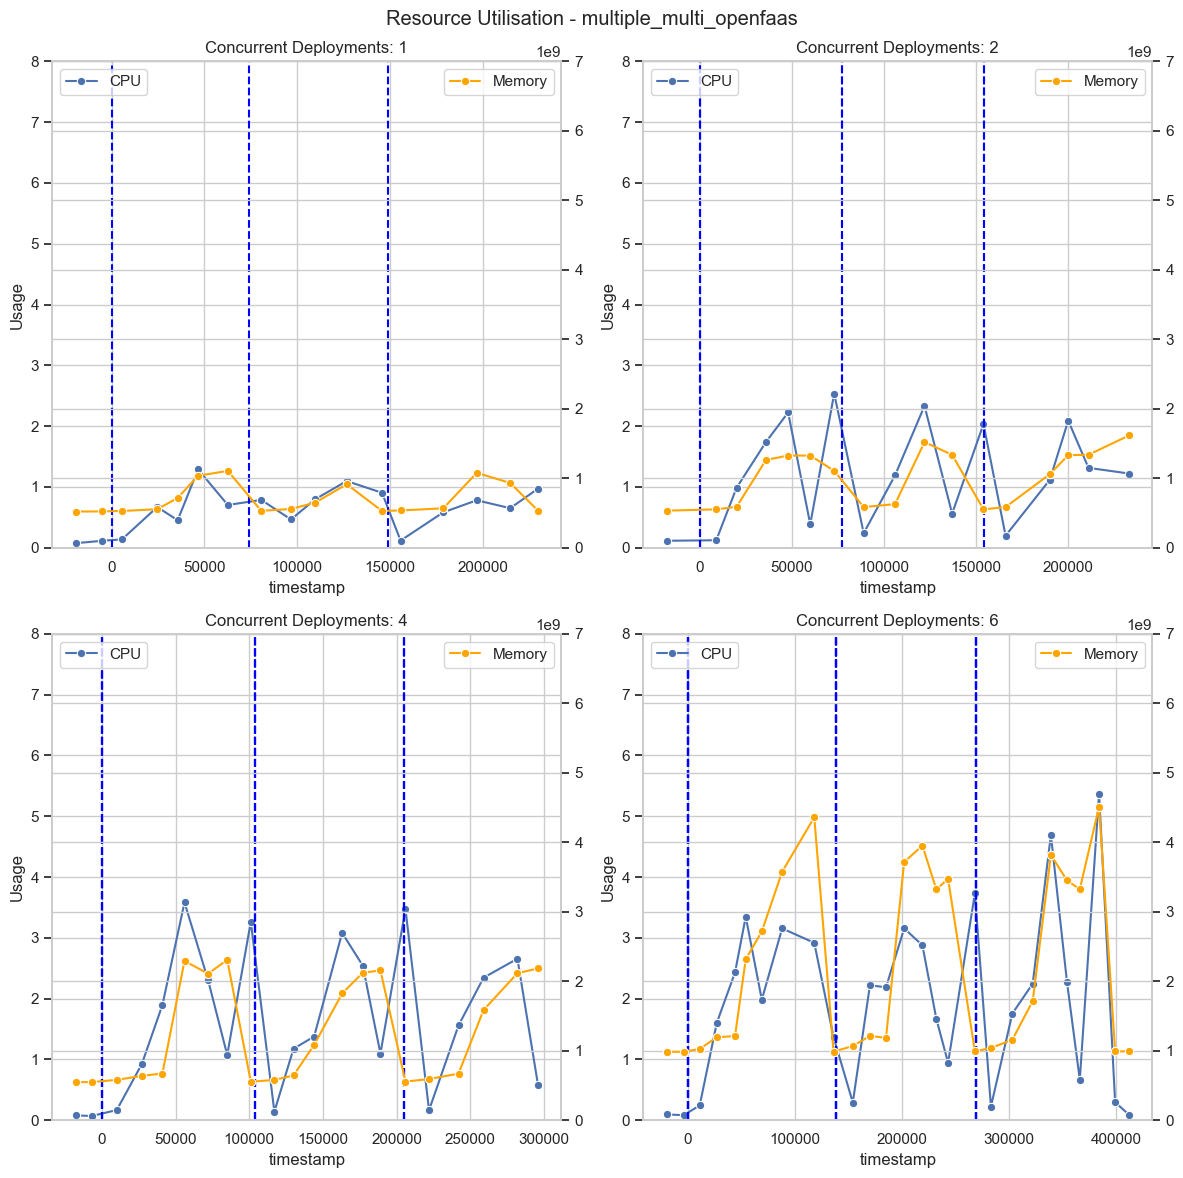

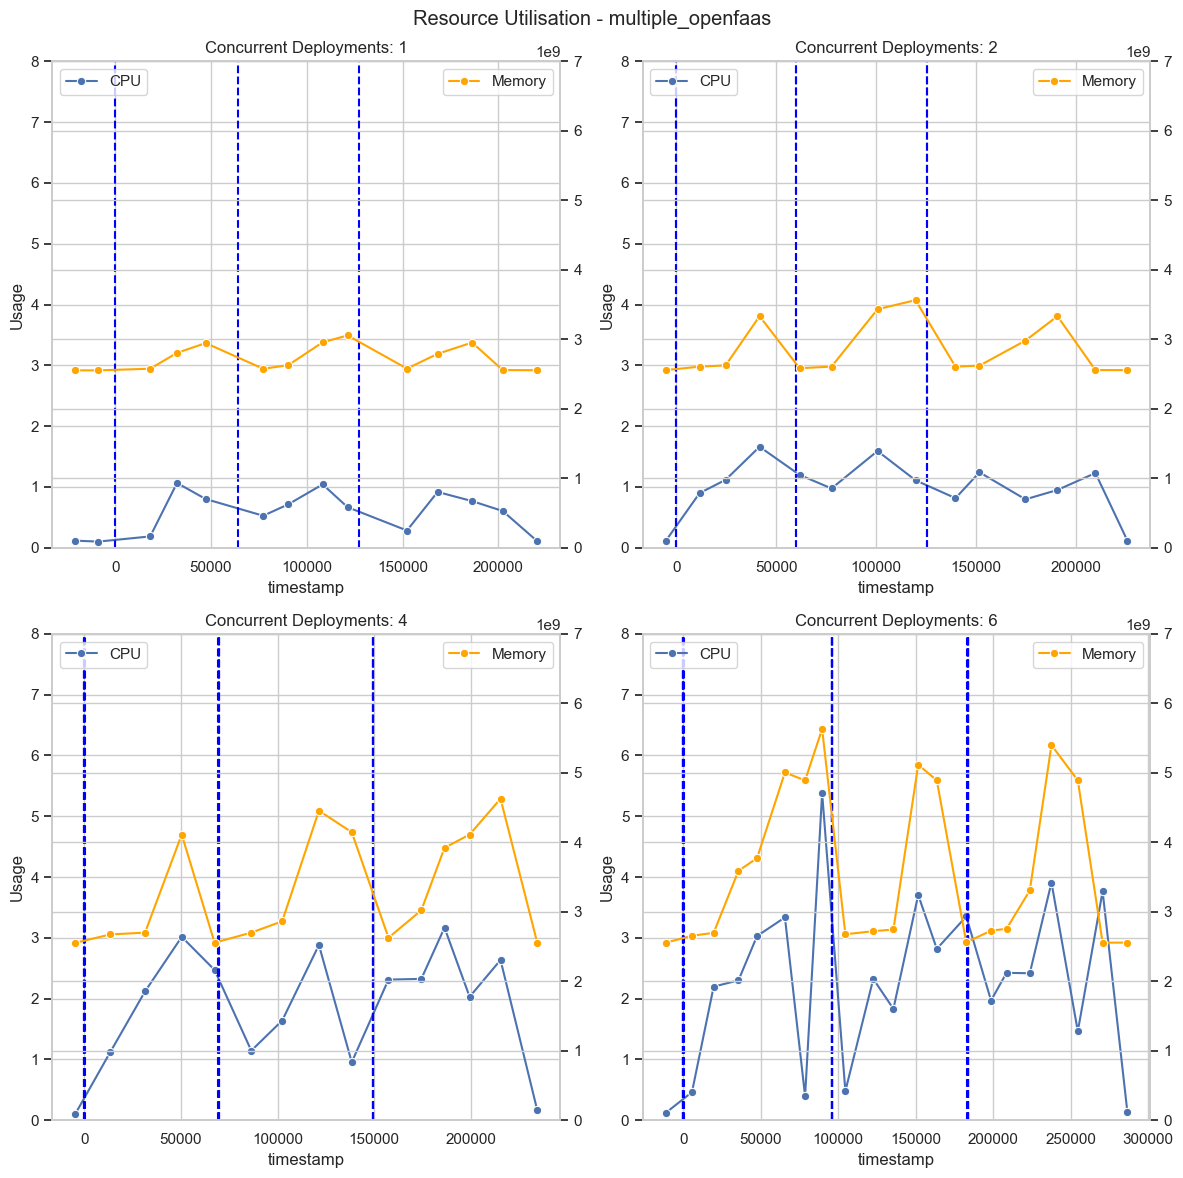

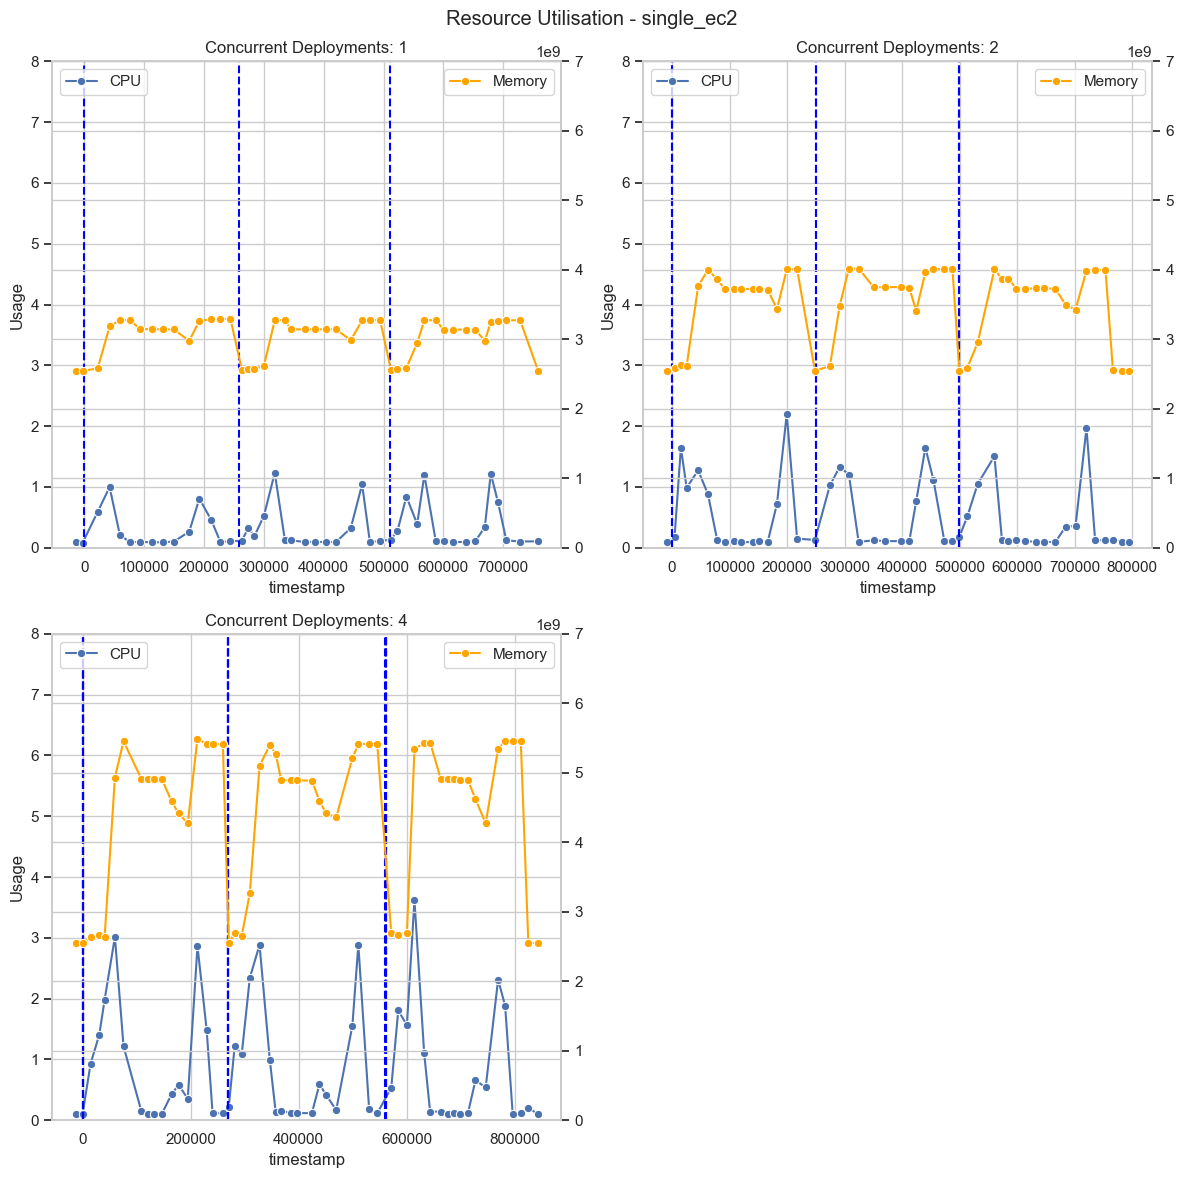

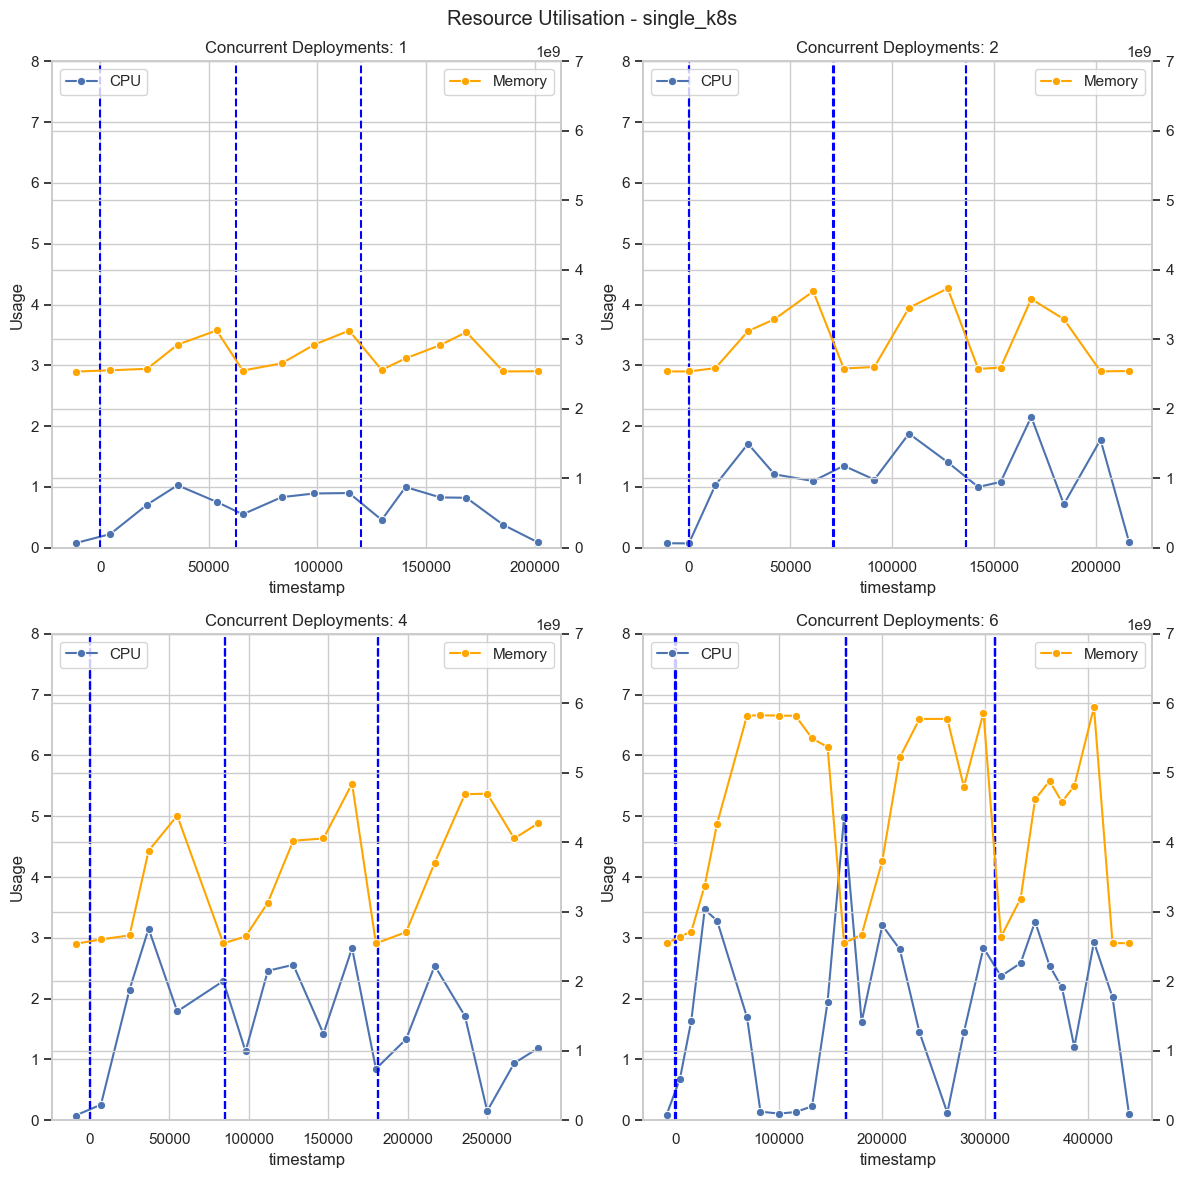

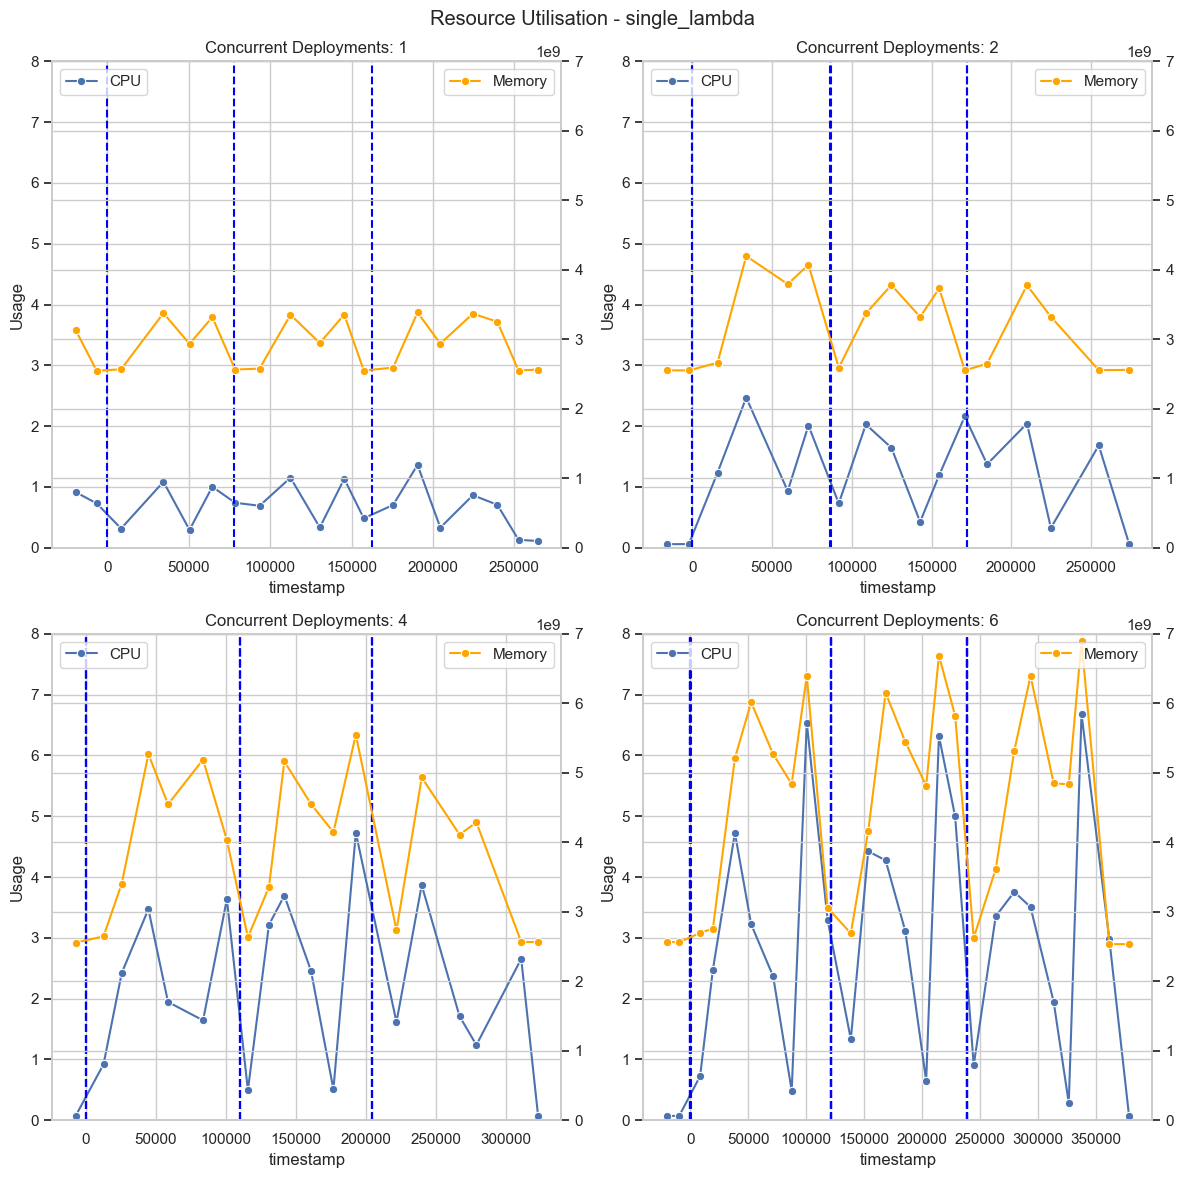

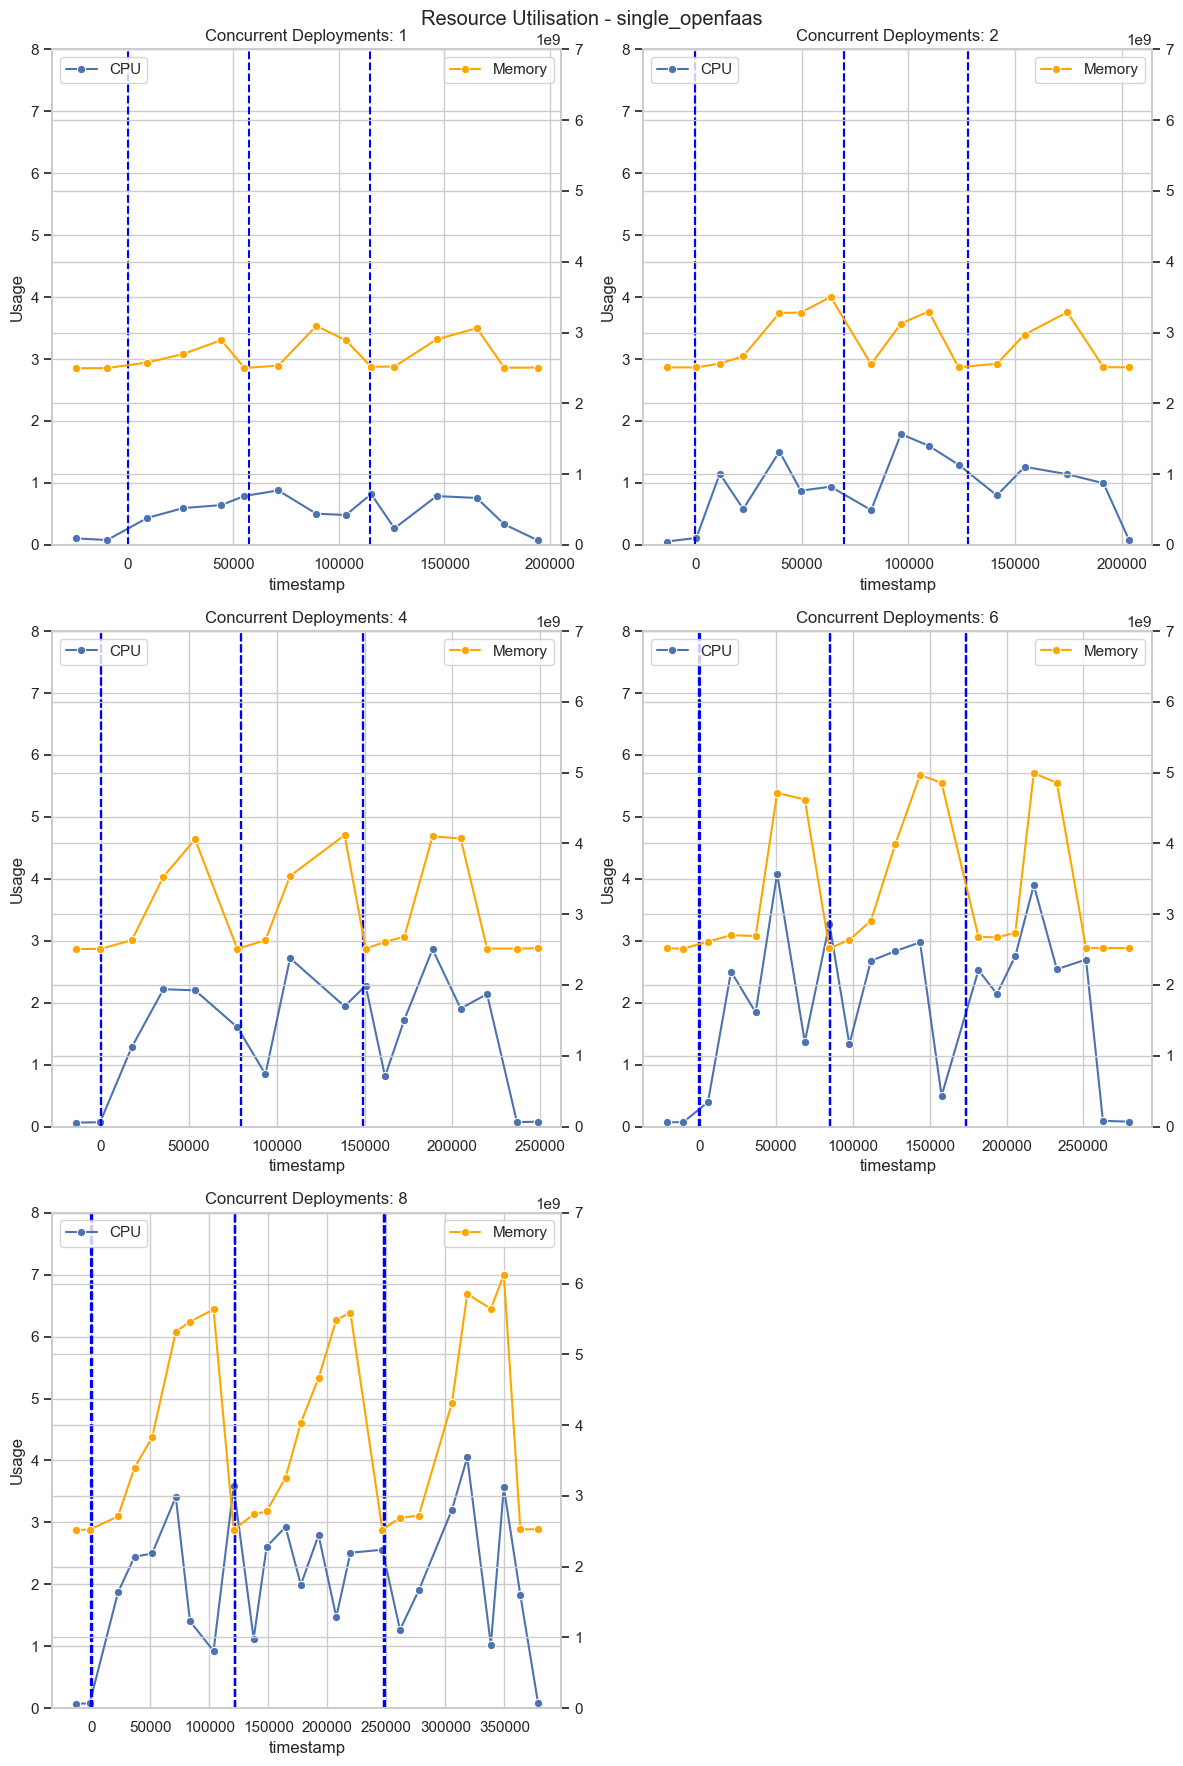

In [155]:
types = df_util['type'].unique()

cpu_min = 0
cpu_max = 8
memory_min = 0
memory_max = 7_000_000_000
for type_ in types:
       type_df = df_util[df_util['type'] == type_]
       concurrent_deployments = type_df['concurrent_deployments'].unique()
       num_subplots = len(concurrent_deployments)
       num_rows = (num_subplots + 1) // 2

       # Check if there is only one subplot needed
       if num_subplots == 1:
              fig, ax = plt.subplots(figsize=(6, 6))
              ax = [ax]
       else:
              fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))
              if isinstance(axs, np.ndarray):
                     ax = axs.ravel().tolist()
                     if num_subplots % 2 != 0:
                            fig.delaxes(ax[-1])

       for i, concurrent_deployment in enumerate(concurrent_deployments):
              concurrent_df = type_df[type_df['concurrent_deployments'] == concurrent_deployment]
              ax[i].set_ylim(cpu_min, cpu_max)
              sns.lineplot(data=concurrent_df, x='timestamp', y='cpu', ax=ax[i], label=f'CPU', marker='o')

              ax_mem = ax[i].twinx()
              sns.lineplot(data=concurrent_df, x='timestamp', y='memory', ax=ax_mem, color='orange', label=f'Memory', marker='o')

              ax_mem.set_ylim(memory_min, memory_max)
              ax[i].set_ylabel('Usage')
              ax[i].set_title(f'Concurrent Deployments: {concurrent_deployment}')
              ax[i].legend(loc='upper left')
              ax_mem.legend(loc='upper right')
              ax_mem.set_ylabel('')
              
              start_times = df_timestamps[(df_timestamps['type'] == type_) & (df_timestamps['concurrent_deployments'] == concurrent_deployment)]['start']
              for start_time in start_times:
                     ax[i].axvline(x=start_time, color='blue', linestyle='--', label='Deployment Start')

       plt.suptitle(f'Resource Utilisation - {type_}')
       plt.tight_layout()
       plt.show()